<a href="https://colab.research.google.com/github/sheeshee/cera-or-eisenberg/blob/master/Cera%20Or%20Eisenberg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Michael Cera Or Jesse Eisenberg?

Do you ever confuse Michael Cera and Jesse Eisenberg? Need some help figuring out which is which? This notebook trains a deep learning network to help you with that very task!

Google Colab can accelerate the training of models. If you are using this platform, make sure that "GPU" is the selected hardware accelerator in _Runtime > Change runtime type_.

## Setup

This notebook is configured to run on Google Colab
These lines are taken from FastAI's Deep Learning Course:
https://course.fast.ai/start_colab.html

In [1]:
# This following command makes sure that Colab is running
# the latest version of FastAI
!curl -s https://course.fast.ai/setup/colab | bash

# This sets up the Notebook to write files to your
# Google Drive
from google.colab import drive
from pathlib import Path
drive.mount('/content/gdrive', force_remount=True)

# Set your paths here
root_dir = "/content/gdrive/My Drive/Colab Notebooks/"
base_dir = root_dir + 'fastai-v3/'
path = Path(base_dir + 'data/cera-or-eisenberg')
path.mkdir(parents=True, exist_ok=True)

# Enable active reloading of libraries
# and in-line display of plots and figures
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Updating fastai...
Done.
Mounted at /content/gdrive


A recent update to Pytorch introduced warnings about
an upcoming change. As of writing this Notebook, FastAI
has not incorparated this change, so some functions spam-
print this warning. The following line disables that warning.

Comment/Uncomment as needed.

In [0]:
import warnings
warnings.filterwarnings(
    "ignore", category=UserWarning,
    module="torch.nn.functional"
)

Import the FastAI functions.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

Set the batch size. This controls how many images are passed to the Learner at once. Because the data set for this excercise is small (~48), I set the batch to a factor of this.

In [0]:
bs = 16 # batch size - we set it to 16 because we have a small dataset

## Load Data

`untar_data` does not seem to work well with 
compressed, online datasets that are outside of the
usual FastAI collection. Thankfully, the user `rkishore` points out a helpful work around. See the [original forum thread](https://forums.fast.ai/t/untar-data-requires-tgz-file-ending/28125/11).

In [5]:
import urllib.request
import tarfile

# This is the url to the tarred datafile on my GitHub repository
# The following code fetches it from here and extracts the images.
data_url = 'https://github.com/sheeshee/cera-or-eisenberg/raw/master/image_data'
local_tgz_path = path/'images.tar.gz'
print('Retrieving...', end='')
urllib.request.urlretrieve(data_url, local_tgz_path); print('Done!')
print('Extracting...', end='')
tarred_file = tarfile.open(local_tgz_path)
tarred_file.extractall(path=path)
tarred_file.close(); print('Done!')

Retrieving...Done!
Extracting...Done!


Load the data into a FastAI data bunch *and* perform any homogenisation/preprocessing necessary for it to be ready to be sent to the Learner.

In [0]:
data = ImageDataBunch.from_folder(
    path,
    ds_tfms=get_transforms(),
    size=299,
    # set no check to true to disable checking of the batch size
    # There are only 48 items in this data set so the batch size should be
    # smaller than this.
    no_check=True, bs=bs
).normalize(imagenet_stats)

You can check on your data with the `show_batch` method

['cera', 'eisenberg']


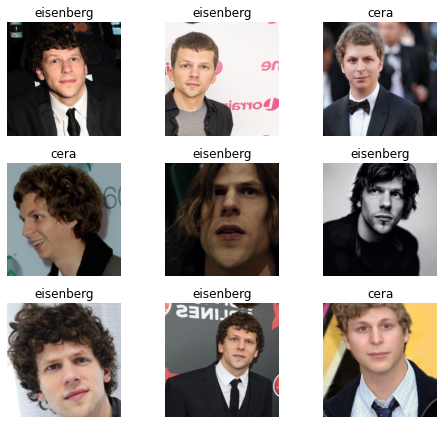

In [7]:
data.show_batch(rows=3, figsize=(7,6))
print(data.classes)

## Load the Learner

The below directive loads the nerual network Resnet50. This will download a pre-trained network from pytorch. It is a highly popular and succesful neural network. It was shown the orginal ImageNet dataset, and can already recognise many general objects. Using a pretrained network will save a bunch of time!

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
# We save the model in case we want to return to this state
learn.save('stage-1') 

## Measure perfomances of different learning rates

Run the `lr_find` method to get insight into how the learning rate impacts the loss metric. This can take a few minutes.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


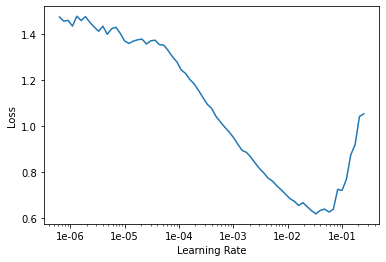

In [9]:
learn.lr_find();
learn.recorder.plot()

## Train the Model

We do an initial fitting of the model to the data. This will give us a benchmark performance and preconfigure the model later for fine tuning.

In [20]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))
learn.save('stage-2')

epoch,train_loss,valid_loss,error_rate,time
0,0.951598,0.782007,0.500000,00:04
1,0.880248,0.646170,0.250000,00:04
2,0.739214,0.582582,0.166667,00:04


View the cases for which the model is the most incorrect or unsure.

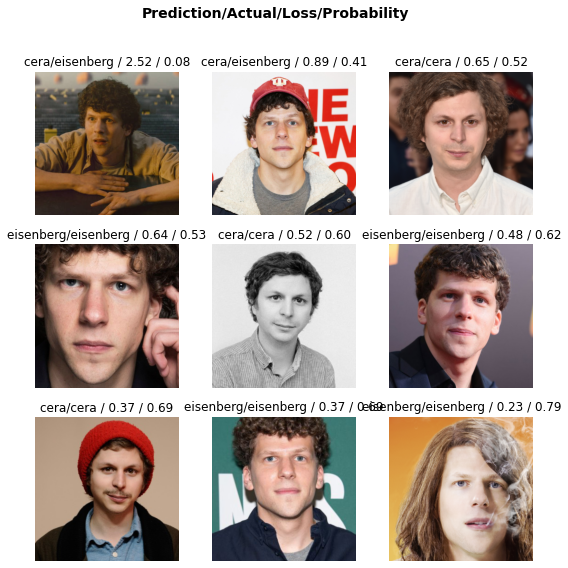

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(9,9))

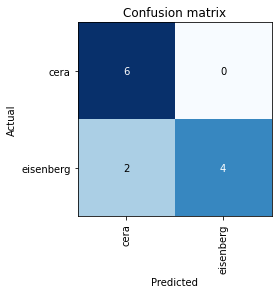

In [22]:
interp.plot_confusion_matrix()

## Fine Tuning

We now unfreeze the layers and retrain the model.

In [0]:
# This allows the model to update the weights in all its
# layers, not just the final one.
learn.unfreeze() 

In [24]:
learn.fit_one_cycle(5, slice(1e-6,1e-4))
learn.save('stage-3')

epoch,train_loss,valid_loss,error_rate,time
0,0.295728,0.545021,0.250000,00:04
1,0.387913,0.459275,0.083333,00:04
2,0.431391,0.360897,0.083333,00:04
3,0.426408,0.315106,0.083333,00:04
4,0.451489,0.304317,0.083333,00:04


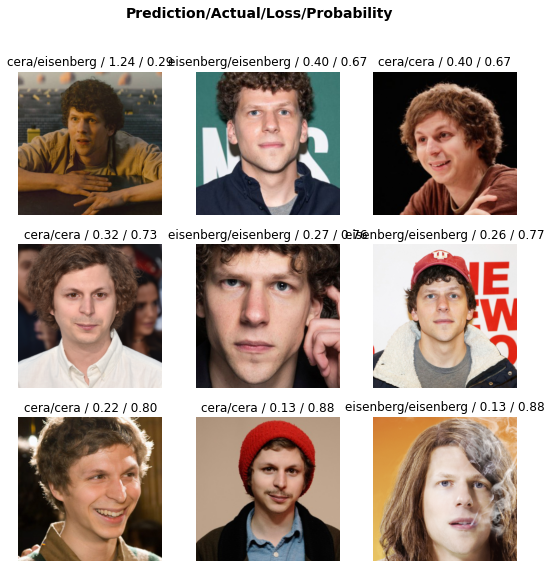

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(9,9))

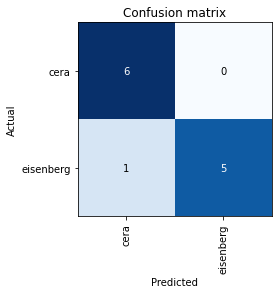

In [26]:
interp.plot_confusion_matrix()

# Now evaluate your own image!

Paste the URL of an image on the internet here, and the model will let you know whether it's Michael Cera or Jesse Eisenberg (~75% reliable).

This is Jesse Eisenberg.
Confidence: 78.41%


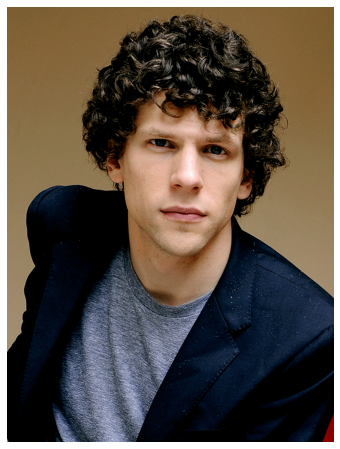

In [27]:
URL = 'https://tvguide1.cbsistatic.com/mediabin/showcards/celebs/j/thumbs/jesse-eisenberg_156879_768x1024.png'

urllib.request.urlretrieve(URL, path/'predict_this')
image = open_image(path/'predict_this')

category, _, probs = learn.predict(image)
image.show(figsize=(8,8))
print(
    "This is %s." % (
    "Michael Cera" if 'cera' == str(category) else "Jesse Eisenberg")
);
print(f"Confidence: {probs[int(category)]*100:.2f}%")

# Final Thoughts

The model itself tends to be biased towards seeing Michael Cera. From a few spot tests with random images, I have observered that the model can be very confident yet still predict incorrectly. 

Its accuracy would no doubt benefit from a larger set training data, but for now, at least it can help you get an idea of at whom exactly you are looking.